# Raman spectra analysis

Importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelmin, argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats import ttest_ind
import seaborn as sns
sns.set_palette('colorblind')

Your measurements should be copied to the "data" folder.
Output results can be saved in "output" polder.

In [2]:
data_directory = 'data/'
out_directory = 'output/'

In case we need to create new folders for each sample:

In [ ]:
dir = "D:/Experiments/Raman/Raman_AP/20241202_Diabone/18122024"
all_files = os.listdir(dir)
filenames = set()
for i in all_files:
        if i.endswith('.csv'):
            modified_file_name = i[:-10] if len(i) > 10 else i
            filenames.add(modified_file_name)

print(filenames)


for f in filenames:
    new_folder_path = os.path.join(dir, f)
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

Reading and combining all .csv files into one dataframe.

In [3]:
def combine_files(data_directory):
    """ Read in all data files and combine into one combined DataFrame
    """
    all_data = pd.DataFrame()
    nameit =[]
    for f in glob.glob(os.path.join(data_directory, "*.csv")):
        df = pd.read_csv(f,skiprows=(30),sep=";")[:-2] #first 30 and the last two rows with the metadata are removed
        n = f.replace(data_directory," ") #getting the names
        n = n.replace("_", " ")[5:-4] # replace symbols from file names 
        df.rename(columns={ df.columns[0]: n }, inplace = True)
        all_data = pd.concat([all_data, df.T])
        nameit.append(n)
    all_data = all_data.astype(float)
    all_data.columns.values.astype(float)
    return all_data, nameit #nameit

Resulting dataframe contains spectral intensities from each measurement in a row-vise manner. The Raman shifts are stored as the column names.

In [4]:
all_data, nameit = combine_files(data_directory)
all_data.head()

,100.00,102.00,104.00,106.00,108.00,110.00,112.00,114.00,116.00,118.00,...,2282.00,2284.00,2286.00,2288.00,2290.00,2292.00,2294.00,2296.00,2298.00,2300.00
01.01.PF.026 spot2,10539.81,10496.12,10290.37,9955.64,9578.06,9174.08,8740.51,8271.89,7798.61,7323.51,...,1579.79,1564.42,1537.90,1550.76,1557.64,1528.27,1545.99,1524.68,1549.42,1524.57
01.01.PF.026 spot4,9103.75,8919.15,8694.81,8453.85,8159.14,7843.04,7502.72,7121.14,6745.23,6383.72,...,1405.74,1417.92,1421.63,1409.86,1428.80,1422.12,1421.68,1405.22,1413.77,1403.42
01.01.PF.026 spot5,8067.76,7891.83,7668.22,7397.10,7118.57,6813.67,6452.16,6073.50,5711.78,5348.00,...,561.89,558.90,549.13,549.00,582.58,546.39,568.09,558.86,568.52,567.18
01.01.PF.026 spot6,8122.04,7935.59,7711.33,7467.83,7192.71,6872.31,6530.01,6150.51,5778.00,5403.35,...,540.80,542.42,530.45,535.02,543.95,542.21,549.57,535.63,530.40,529.22
01.01.PF.026 spot7,8172.99,7961.65,7713.69,7438.30,7134.57,6806.41,6462.50,6074.24,5676.01,5305.34,...,512.60,537.96,541.87,528.72,535.21,536.06,528.14,537.49,526.33,532.85


Creating function for the plots:

In [5]:
def plot_dataframe(frame,out_directory,legendnames, filename, cutraw = False, legend = True, cut = False, show = False):
    """ Save plot of dataframe to a specified file and location
        cut = True to cut noisy part on the sides
        legends collected from the file name list, too much to write on figure
    """
    plot_file = os.path.join(out_directory, filename)
    plt.ioff()         
    fig = plt.figure(figsize=(9, 6), dpi=300)
    shifts = frame.columns.values.astype(float)
    for idx in range(frame.shape[0]):
        plt.plot(shifts,frame.iloc[idx],'-',linewidth=1)
    plt.xlabel('Shift cm$^{-1}$', fontsize=14)
    plt.ylabel('Intensity (a.u.)', fontsize=14)
    if legend:
        fig.legend(legendnames, bbox_to_anchor=(0.95,0.9), facecolor="white", loc="upper left",fontsize=12)
    plt.grid(True)
    ax = plt.gca()
    ax.set_autoscale_on(True)
    ax.set_facecolor("whitesmoke")
    plt.box(True)
    if cut:
        cut_index_start = round(frame.shape[1]*0.05)
        cut_index_end = round(frame.shape[1]*0.9)
        xlim = np.append(frame.columns.values[cut_index_start],frame.columns.values[cut_index_end])# left and right boundaries for x axis
        ax.set_xlim(xlim) # set x axis boundaries
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    if show:
        plt.show()
    plt.close(fig)

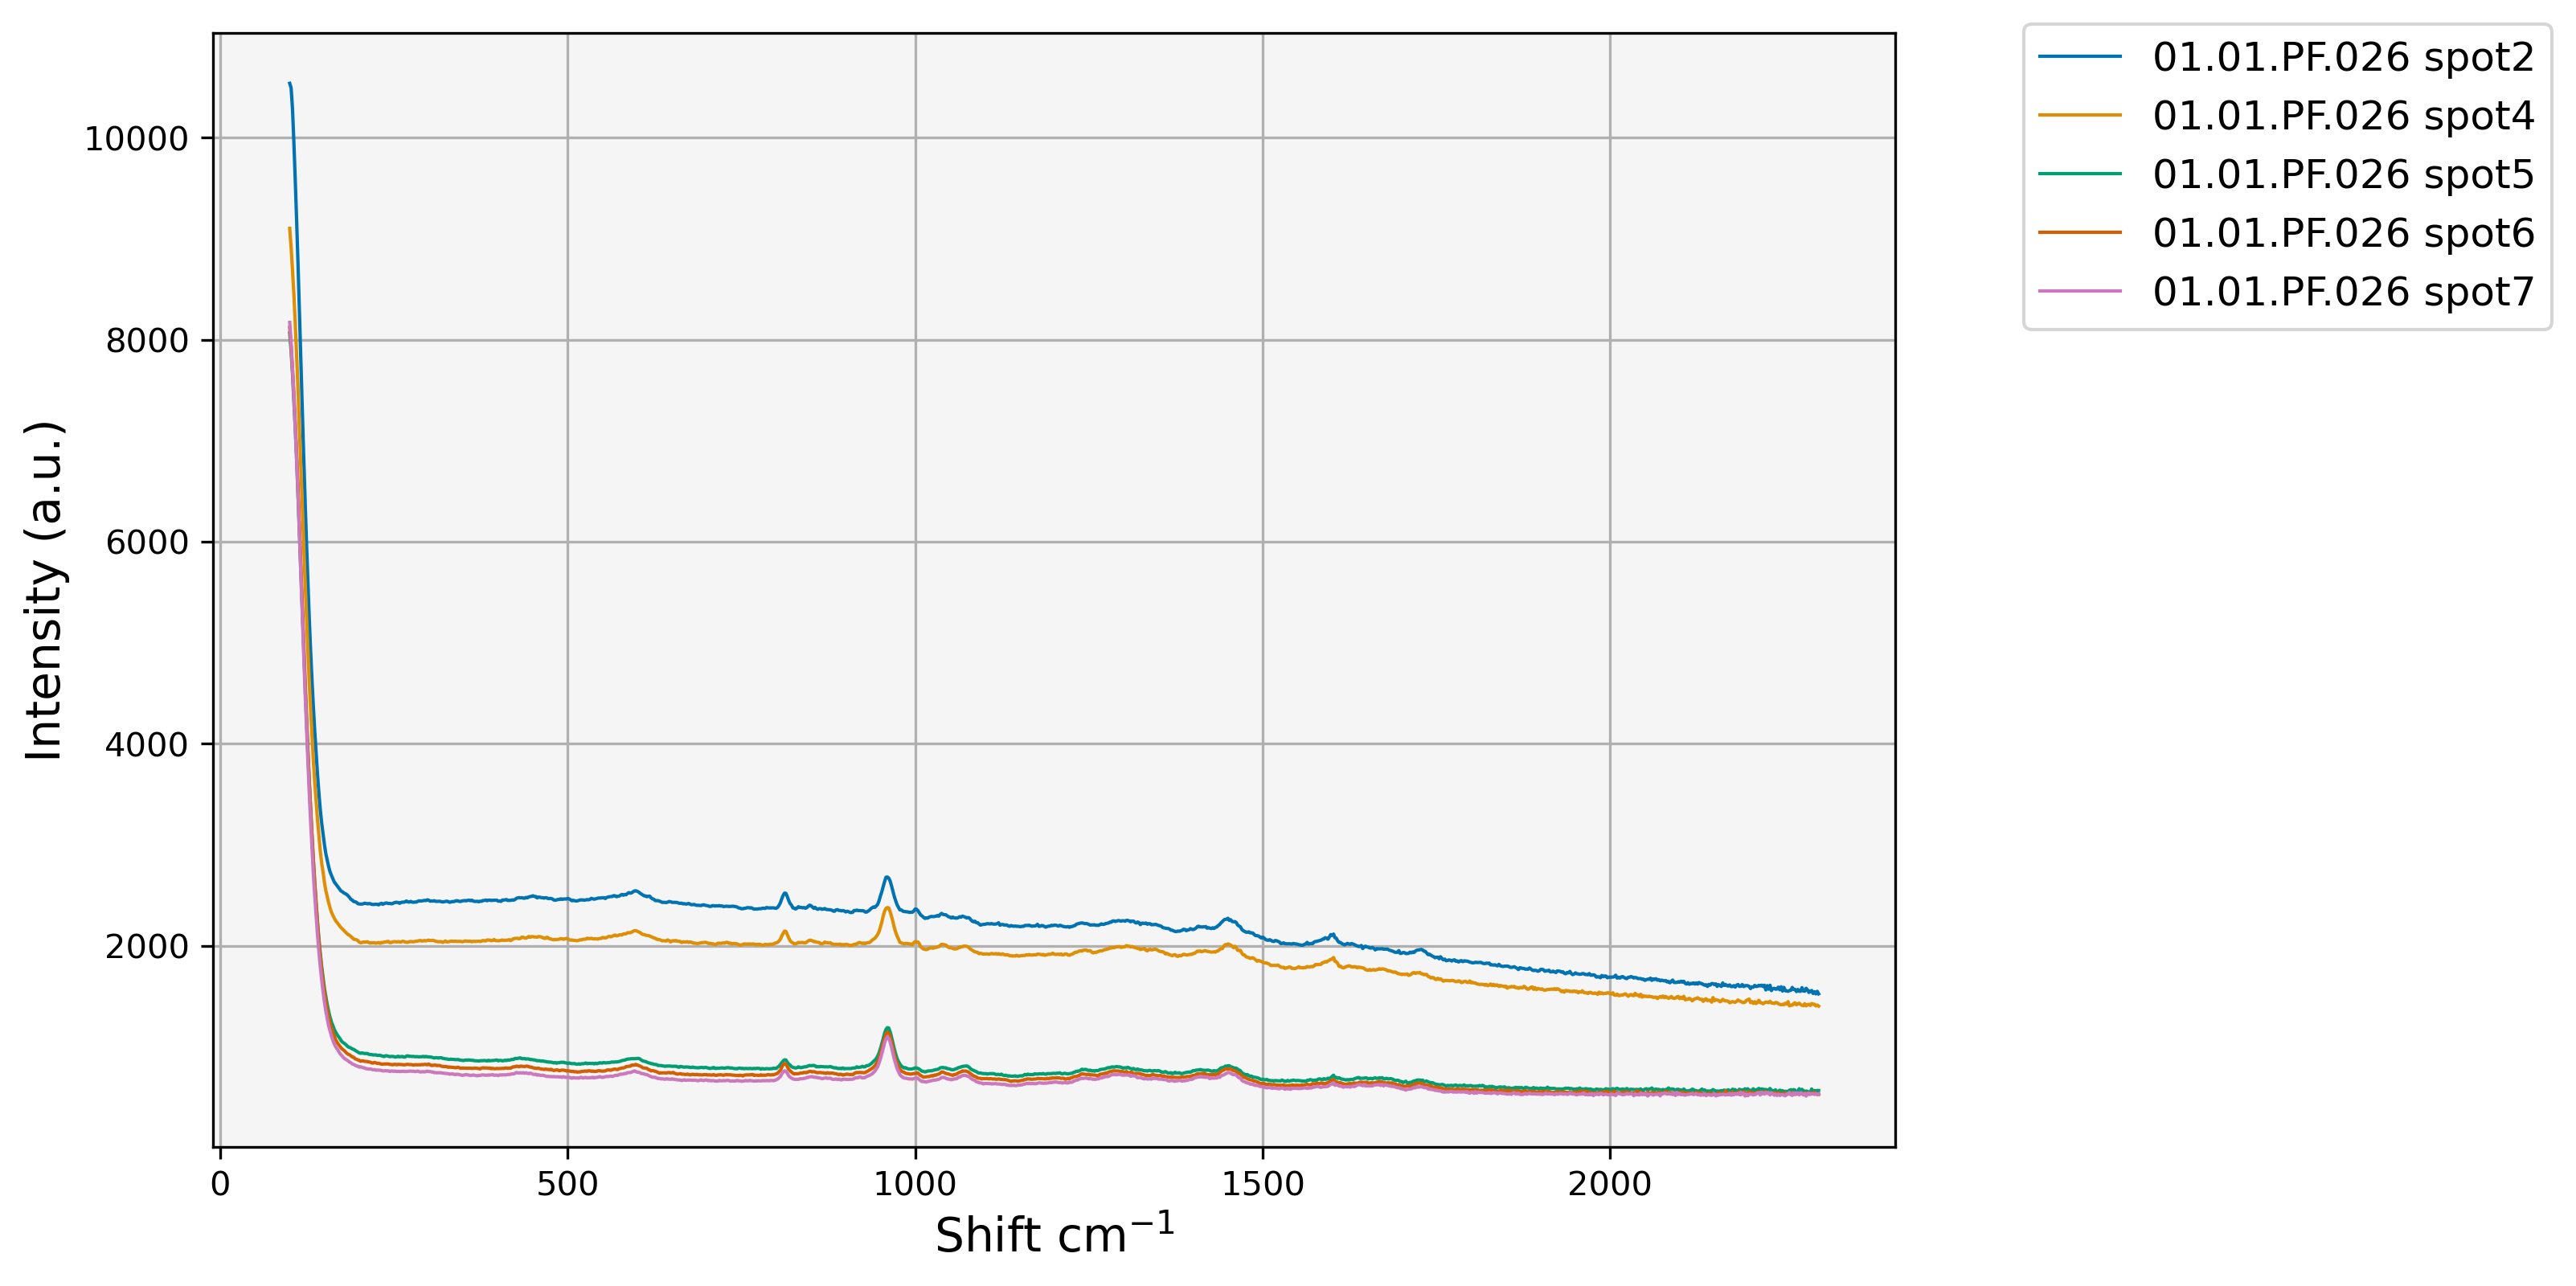

In [6]:
plot_dataframe(all_data,out_directory,nameit, 'RawData_All.png', show = True) # BG subtracted data plot

Backgroud substraction from the whole spectra:

In [7]:
def subtract_BG(frame, fitorder):
    """BG subtraction of the chosen fitorder
        extracts the BG based on the polynomial fit of the local minimas through the whole spectra
    """
    fit_index_start = round(frame.shape[1]*0.05)
    fit_index_end = round(frame.shape[1]*0.90)
    shifts = pd.DataFrame(frame.columns.values[fit_index_start:fit_index_end]).astype(float).T 
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) #gets shifts without the first noisy peak and the last long "tail"
    minindex = pd.DataFrame()
    ymin = pd.DataFrame()
    xmin = pd.DataFrame()
    n = 20 # number of points to be checked before and after for min counts values
    for row in range(counts.shape[0]):
        minindex = pd.concat([minindex, pd.DataFrame(argrelextrema(counts.values[row,:], np.less_equal, order=n)[0]).T]).reset_index(drop=True) # gives a dataframe of indexes with minimal values
    minindex = minindex.fillna(counts.shape[1]-1) #to exclude NaN values fill in with the last index
    for row in range(counts.shape[0]):
        ymin = pd.concat([ymin, pd.DataFrame(counts.loc[row, minindex.values[row,:]].values).T]).reset_index(drop=True)
        xmin = pd.concat([xmin, pd.DataFrame(shifts.loc[:, minindex.values[row,:]].values)]).reset_index(drop=True) 
    ############# Fitting BG ############
    BGcounts = pd.DataFrame() #Background counts from linear fit
    p = pd.DataFrame() #parameters of linear fit y = p[0]*x + p[1]
    corrcounts = pd.DataFrame()
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) # [:, 210:-290] update to remove shifts from the column names and perform subtraction afterwards
    for row in range(counts.shape[0]):
        p = pd.concat([p, pd.DataFrame(np.polyfit(xmin.values[row,:], ymin.values[row,:], fitorder)).T]).reset_index(drop=True)
    for row in range(counts.shape[0]):
        BGcounts = pd.concat([BGcounts, pd.DataFrame(np.polyval(p.values[row,:], shifts.values))]).reset_index(drop=True)
    corrcounts = counts.sub(BGcounts, fill_value=0) #subtracting BG 
    corrcounts.columns = shifts.T[0]   
    return corrcounts

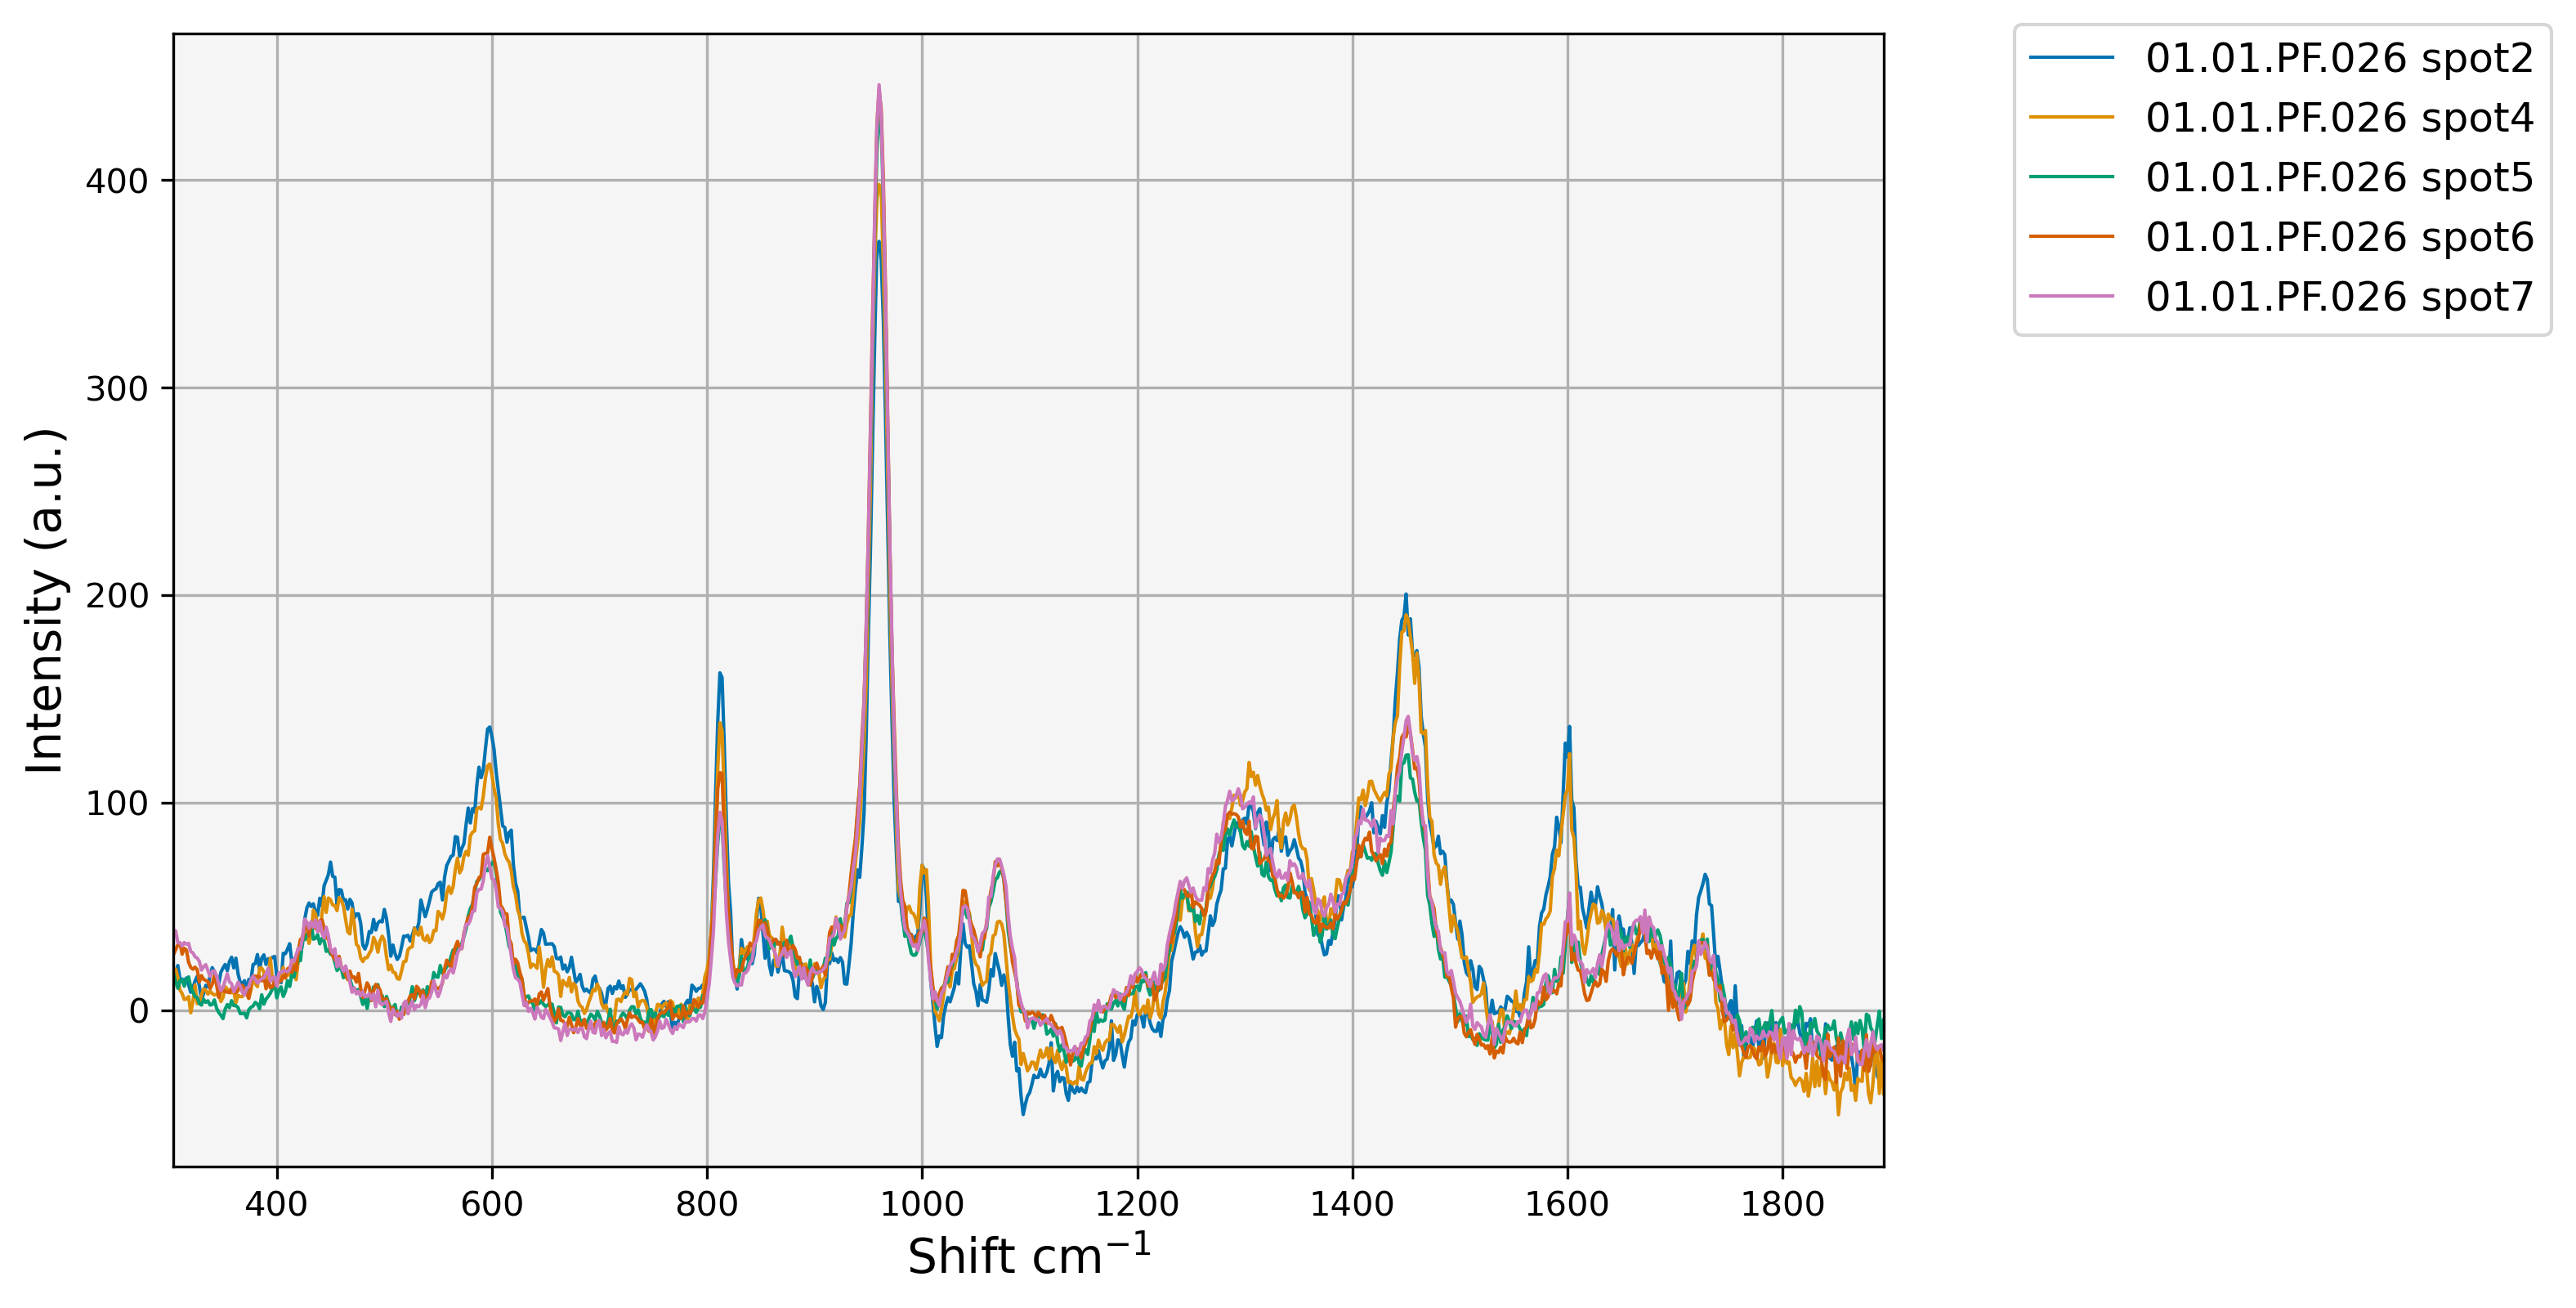

In [8]:
corrcounts = subtract_BG(all_data,fitorder=3)  # BG subtraction from ALL data
plot_dataframe(corrcounts,out_directory,nameit,'BGdata_All.png', cut = True, show = True) # BG subtracted data plot

Supplementary functions to fit Raman bands:

In [9]:
def subtract_peakBG(peakshifts, peakcounts): 
    """ Subtract BG from peak. Does linear fit through the left and right sides of the peak and subtracts it.
    """
    peak_shifts = pd.DataFrame(peakshifts).T
    peak_counts = pd.DataFrame(peakcounts) #get shifts without the first noisy peak in df format to use .iloc 
    x_left = pd.DataFrame(peak_shifts.values[0,0:5])
    x_right = pd.DataFrame(peak_shifts.values[0,-6:-1])
    #x_sides = pd.concat([x_left,x_right])
    x_sides = np.append(x_left, x_right)
    BGcounts = pd.DataFrame()
    p = pd.DataFrame()
    for row in range(peak_counts.shape[0]):
        y_left = pd.DataFrame(peak_counts.values[row,0:5])
        y_right = pd.DataFrame(peak_counts.values[row,-6:-1])
        y_sides = pd.concat([y_left, y_right])
        p = pd.concat([p,pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T]).reset_index(drop=True)
    for row in range(peak_counts.shape[0]):
        BGcounts = pd.concat([BGcounts,pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values))]).reset_index(drop=True)
    peak_corrcounts = peak_counts.sub(BGcounts, fill_value=0) #subtracting BG
    peak_corrcounts.columns = peak_shifts.T[0]
    return peak_corrcounts

# we use two function types for the Raman bands fit: single and double Lorentzian
def lorentzian(x, *p):        
        # p = [hwhm, peak center, intensity]
        numerator =  ( p[0]**2 )
        denominator = ( x - (p[1]) )**2 + p[0]**2
        y = p[2]*(numerator/denominator)
        return y 

def doublelorentzian(x, *p):        
        # p = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)
        return y 

def triplelorentzian(x, *p):        
        # p = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        numerator2 =  ( p[6]**2 )
        denominator2 = ( x - (p[7]) )**2 + p[6]**2        
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)+p[8]*(numerator2/denominator2)
        return y 

def quadruplelorentzian(x, *p):        
        # p = [[0]-hwhm #1, [1]-peak center #1, [2]-intensity #1, [3]-hwhm #2, [4]-peak center #2, [5]-intensity #2
        #       [6]-hwhm #3, [7]-peak center #3, [8]-intensity #3, [9]-hwhm #4, [10]-peak center #4, [11]-intensity #4]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        numerator2 =  ( p[6]**2 )
        denominator2 = ( x - (p[7]) )**2 + p[6]**2    
        numerator3 =  ( p[9]**2 )
        denominator3 = ( x - (p[10]) )**2 + p[9]**2   
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)+p[8]*(numerator2/denominator2)+p[11]*(numerator3/denominator3)
        return y 

    


In [10]:
# in accordance with the fitting function, we have two functions for calculating hte fitted Raman band properties
def peak_fit(peak_shifts, peak_corrcounts, plot = False): #if plot -> shows intermediate fittings
    """ Lorentzian fit 
    p0 = [hwhm #1, peak center #1, intensity #1]
    """
    x = peak_shifts
    peak_pos = []
    peak_FWHM = []
    peak_intensity = []
    peak_integral = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        p0 = [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)] 
        popt, pcov = curve_fit(lorentzian, x, y, p0)
        peak_pos = np.append(peak_pos, popt[1])
        peak_FWHM = np.append(peak_FWHM, popt[0])
        peak_intensity = np.append(peak_intensity, lorentzian(popt[1], *popt))  #maximum: 2.99846874275 18.3928199902
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: lorentzian(x, *popt), min(x), max(x))[0])
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=300)
            x_curve = np.linspace(min(x), max(x), 50)
            plt.plot(x, y,'k.', fillstyle='none')
            plt.plot(x_curve, lorentzian(x_curve, *popt), color = 'grey')
            plt.plot(x_curve, lorentzian(x_curve, *popt), 'k.', fillstyle='none')
            plt.show()
    return peak_pos, peak_intensity, peak_FWHM, peak_integral

def doublepeak_fit(peak_shifts, peak_corrcounts, plot = False, amideI = False, amideIII = False, v2PO4 = False): #enable plot to see each peak fitting
    """ Double Lorentzian fit 
        p0 = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
    """
    x = peak_shifts
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        if amideI: #left shoulder~1640 cm-1, right peak~1670 cm-1
            color = 'orange'
            bounds = ([0, 1625, 0, 0, 1655,0], [1e6, 1650, 0.75*(max(y)), 1e6, 1680, 1e6]) # bounds for pO, for beter fitting
            p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
            p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        if amideIII: #left peak ~1242 cm-1; right peak ~1272 cm-1
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
            p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)] 
            color = 'tomato'
        if v2PO4: #main peak~431 cm-1, right shoulder~450 cm-1
            color = 'blue'
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 420, 0, 0, 445,0], [1e6, 440, 1e6, 1e6, 465, 1e5]) 
            p0 = [2.055*np.std(xleft)/2.0,  431, max(yleft), 2.055*np.std(xright)/2.0,  454, max(yright)]             
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=400)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = color) 
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') 
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') 
            plt.show()
    return peak_pos_left, peak_intensity_left, peak_pos_right, peak_intensity_right, peak_integral 

Analysing Raman bands of interest:

### Amide I

In [11]:
def amideI_analysis_double(corrcounts, directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         left shoulder~1645 cm-1, right peak~1665 cm-1
     OUTPUT: [0] peak position of amide I left shoulder, [1] peak intensity of amide I left shoulder, 
             [2] position of amide I right peak, [3] intensity of amide I right peak

    """
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1510.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1760.)[0][0]
    amideI_counts = corrcounts.values[:,start_index:end_index] 
    amideI_shifts = shifts.values[0,start_index:end_index]
    amideI_corrcounts = subtract_peakBG(amideI_shifts, amideI_counts) #subtracting BG from amideI peak
    if peak_plot:
        plot_dataframe(amideI_corrcounts,directory,nameit, 'BGsubtracted_amideI.png') # and plot it
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideI_shifts
    for row in range(amideI_corrcounts.shape[0]):
        y = amideI_corrcounts.values[row,:]
        bounds = ([0, 1585, 0, 0, 1645,0], [1e6, 1640, 0.75*(max(y)), 1e6, 1700, 1e6]) # bounds for pO, for beter fitting
        p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
        p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'orange') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()
    amideI_param = {'amideI_pos_left': peak_pos_left, 
                 'amideI_intensity_left': peak_intensity_left, 
                 'amideI_pos_right': peak_pos_right, 
                 'amideI_intensity_right': peak_intensity_right, 
                 'amideI_integral': peak_integral}
    amideI_param = pd.DataFrame(data = amideI_param)
    return(amideI_param)

In [12]:
def amideI_analysis_triple(corrcounts, directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         left shoulder~1645 cm-1, right peak~1665 cm-1
     OUTPUT: [0] peak position of amide I left shoulder, [1] peak intensity of amide I left shoulder, 
             [2] position of amide I right peak, [3] intensity of amide I right peak

    """
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1520.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1716.)[0][0]
    amideI_counts = corrcounts.values[:,start_index:end_index] 
    amideI_shifts = shifts.values[0,start_index:end_index]
    amideI_corrcounts = subtract_peakBG(amideI_shifts, amideI_counts) #subtracting BG from amideI peak
    if peak_plot:
        plot_dataframe(amideI_corrcounts,directory,nameit, 'BGsubtracted_amideI.png') # and plot it
    peak_pos_1 = pd.DataFrame()
    peak_intensity_1 = pd.DataFrame()
    peak_pos_2 = pd.DataFrame()
    peak_intensity_2 = pd.DataFrame()
    peak_pos_3 = pd.DataFrame()
    peak_intensity_3 = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideI_shifts
    for row in range(amideI_corrcounts.shape[0]):
        y = amideI_corrcounts.values[row,:]
        x1 = x[:len(x)//2] # splitting peak data in three parts
        x2 = x[len(x)//2:] #the rest 2/3 of array further splitted in two parts
        x3 = x2[len(x2)//2:]
        x2 = x2[:len(x2)//2]
        y1 = y[:len(y)//2] # splitting peak data in three parts
        y2 = y[len(y)//2:] #the rest 2/3 of array further splitted in two parts
        y3 = y2[len(y2)//2:]
        y2 = y2[:len(y2)//2]

        bounds = ([0, 1570, 0, 0, 1615, 0, 0, 1660,0], [1e6, 1610, 1e6, 1e6, 1655, 1e6, 1e5, 1716, 1e5]) # p = [hwhm #i, peak center #i, intensity #i, ...]
        p0 = [2.055*np.std(x1)/2.0,  1600, max(y1), 2.055*np.std(x2)/2.0,  1640, max(y2), 2.055*np.std(x3)/2.0,  1680, max(y3)]             

        #bounds = ([0, 1585, 0, 0, 1645,0], [1e6, 1640, 0.75*(max(y)), 1e6, 1700, 1e6]) # bounds for pO, for beter fitting
        #p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
        #p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        popt, pcov = curve_fit(triplelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_1 = np.append(peak_pos_1, popt[1])
        peak_intensity_1 = np.append(peak_intensity_1, triplelorentzian(popt[1], *popt))
        peak_pos_2 = np.append(peak_pos_2, popt[4])
        peak_intensity_2 = np.append(peak_intensity_2, triplelorentzian(popt[4], *popt)) 
        peak_pos_3 = np.append(peak_pos_3, popt[7])
        peak_intensity_3 = np.append(peak_intensity_3, triplelorentzian(popt[7], *popt))
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: triplelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, triplelorentzian(x_curve, *popt), color = 'orange') 
            plt.plot(popt[1], triplelorentzian(popt[1], *popt), 'k.')
            plt.plot(popt[4], triplelorentzian(popt[4], *popt), 'k.')
            plt.plot(popt[7], triplelorentzian(popt[7], *popt), 'k.') 
            plt.show()
    amideI_param = {'amideI_pos_1': peak_pos_1, 
                    'amideI_intensity_1': peak_intensity_1, 
                    'amideI_pos_2': peak_pos_2, 
                    'amideI_intensity_2': peak_intensity_2, 
                    'amideI_pos_3': peak_pos_3, 
                    'amideI_intensity_3': peak_intensity_3, 
                    'amideI_integral': peak_integral}
    amideI_param = pd.DataFrame(data = amideI_param)
    return(amideI_param)

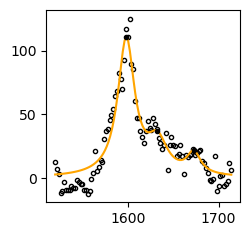

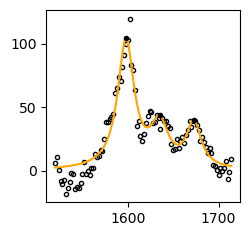

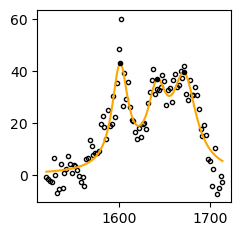

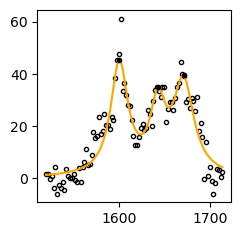

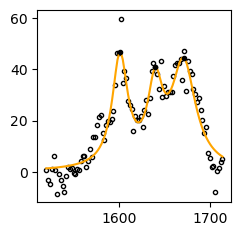

In [13]:
amideI_param = amideI_analysis_triple(corrcounts, out_directory, fit_plot = True)

### Amide III

In [14]:
def amideIII_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
             left peak ~1242 cm-1; right peak ~1272 cm-1
         OUTPUT: [0] position of amide III left peak, [1] intensity of amide III left peak, 
                 [2] position of amide III right peak, [3] intensity of amide III right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1220.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1340.)[0][0]

    amideIII_counts = corrcounts.values[:,start_index:end_index] 
    amideIII_shifts = shifts.values[0,start_index:end_index]
    amideIII_corrcounts = subtract_peakBG(amideIII_shifts, amideIII_counts) #subtracting BG from amideIII peak
    if peak_plot:
        plot_dataframe(amideIII_corrcounts,src_directory,nameit, 'BGsubtracted_amideIII.png') # and plot it
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideIII_shifts
    for row in range(amideIII_corrcounts.shape[0]):
        y = amideIII_corrcounts.values[row,:]
        xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
        xright = x[len(x)//2:]
        yleft = y[:len(y)//2]  
        yright = y[len(y)//2:] 
        bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
        p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)]     
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'tomato') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()
    amideIII_param = {'amideIII_pos_left': peak_pos_left, 
                 'amideIII_intensity_left': peak_intensity_left, 
                 'amideIII_pos_right': peak_pos_right, 
                 'amideIII_intensity_right': peak_intensity_right, 
                 'amideIII_integral': peak_integral}
    amideIII_param = pd.DataFrame(data = amideIII_param)    
    return(amideIII_param)

In [15]:
def amideIII_analysis_triple(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
             left peak ~1242 cm-1; right peak ~1272 cm-1
         OUTPUT: [0] position of amide III left peak, [1] intensity of amide III left peak, 
                 [2] position of amide III right peak, [3] intensity of amide III right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1220.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1340.)[0][0]

    amideIII_counts = corrcounts.values[:,start_index:end_index] 
    amideIII_shifts = shifts.values[0,start_index:end_index]
    amideIII_corrcounts = subtract_peakBG(amideIII_shifts, amideIII_counts) #subtracting BG from amideIII peak
    if peak_plot:
        plot_dataframe(amideIII_corrcounts,src_directory,nameit, 'BGsubtracted_amideIII.png') # and plot it
    peak_pos_1 = pd.DataFrame()
    peak_intensity_1 = pd.DataFrame()
    peak_pos_2 = pd.DataFrame()
    peak_intensity_2 = pd.DataFrame()
    peak_pos_3 = pd.DataFrame()
    peak_intensity_3 = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideIII_shifts
    for row in range(amideIII_corrcounts.shape[0]):
        y = amideIII_corrcounts.values[row,:]
        x1 = x[:len(x)//2] # splitting peak data in three parts
        x2 = x[len(x)//2:] #the rest 2/3 of array further splitted in two parts
        x3 = x2[len(x2)//2:]
        x2 = x2[:len(x2)//2]
        y1 = y[:len(y)//2] # splitting peak data in three parts
        y2 = y[len(y)//2:] #the rest 2/3 of array further splitted in two parts
        y3 = y2[len(y2)//2:]
        y2 = y2[:len(y2)//2]

        bounds = ([0, 1230, 0, 0, 1265, 0, 0, 1300,0], [1e6, 1260, 1e6, 1e6, 1295, 1e6, 1e5, 1330, 1e5]) # p = [hwhm #i, peak center #i, intensity #i, ...]
        p0 = [2.055*np.std(x1)/2.0,  1240, max(y1), 2.055*np.std(x2)/2.0,  1290, max(y2), 2.055*np.std(x3)/2.0,  1310, max(y3)]             

        #bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
        #p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)]  
        popt, pcov = curve_fit(triplelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_1 = np.append(peak_pos_1, popt[1])
        peak_intensity_1 = np.append(peak_intensity_1, triplelorentzian(popt[1], *popt))
        peak_pos_2 = np.append(peak_pos_2, popt[4])
        peak_intensity_2 = np.append(peak_intensity_2, triplelorentzian(popt[4], *popt)) 
        peak_pos_3 = np.append(peak_pos_3, popt[7])
        peak_intensity_3 = np.append(peak_intensity_3, triplelorentzian(popt[7], *popt))
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: triplelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, triplelorentzian(x_curve, *popt), color = 'tomato') 
            plt.plot(popt[1], triplelorentzian(popt[1], *popt), 'k.')
            plt.plot(popt[4], triplelorentzian(popt[4], *popt), 'k.')
            plt.plot(popt[7], triplelorentzian(popt[7], *popt), 'k.') 
            plt.show()
    amideIII_param = {'amideIII_pos_1': peak_pos_1, 
                    'amideIII_intensity_1': peak_intensity_1, 
                    'amideIII_pos_2': peak_pos_2, 
                    'amideIII_intensity_2': peak_intensity_2, 
                    'amideIII_pos_3': peak_pos_3, 
                    'amideIII_intensity_3': peak_intensity_3, 
                    'amideIII_integral': peak_integral}
    amideIII_param = pd.DataFrame(data = amideIII_param)
    return(amideIII_param)

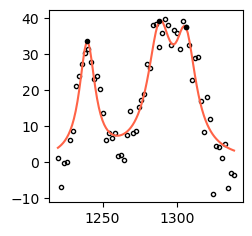

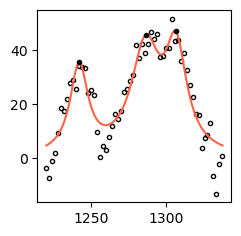

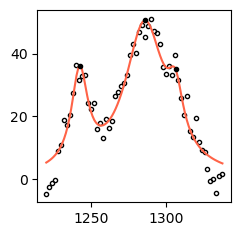

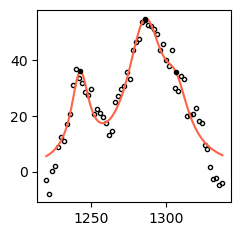

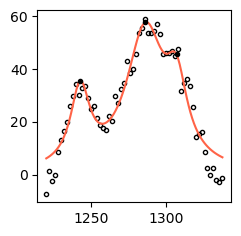

In [16]:
amideIII_param = amideIII_analysis_triple(corrcounts, out_directory, fit_plot = True)

### $v_1PO_4$

In [17]:
def v1PO4_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
             peak ~960 cm-1           
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 920.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1000.)[0][0]
    v1PO4_counts = corrcounts.values[:,start_index:end_index] 
    v1PO4_shifts = shifts.values[0,start_index:end_index]
    v1PO4_corrcounts = subtract_peakBG(v1PO4_shifts, v1PO4_counts) #subtracting BG from  v2PO4
    if peak_plot:
        plot_dataframe(v1PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v1PO4.png') # and plot it
        
    peak_pos = []
    peak_FWHM = []
    peak_intensity = []
    peak_integral = pd.DataFrame()
    x = v1PO4_shifts
    for row in range(v1PO4_corrcounts.shape[0]):
        y = v1PO4_corrcounts.values[row,:]
        p0 = [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)] 
        popt, pcov = curve_fit(lorentzian, x, y, p0)
        peak_pos = np.append(peak_pos, popt[1])
        peak_FWHM = np.append(peak_FWHM, 2*popt[0])
        peak_intensity = np.append(peak_intensity, lorentzian(popt[1], *popt))
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: lorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y,'k.', fillstyle='none')
            plt.plot(x_curve, lorentzian(x_curve, *popt), color = 'grey')
            plt.plot(x_curve, lorentzian(x_curve, *popt), 'k.', fillstyle='none')
            plt.show()
    v1PO4_param = {'v1PO4_pos': peak_pos, 
                'v1PO4_intensity': peak_intensity, 
                'v1PO4_FWHM': peak_FWHM, 
                'v1PO4_integral': peak_integral}
    v1PO4_param = pd.DataFrame(data = v1PO4_param)
    return(v1PO4_param)  


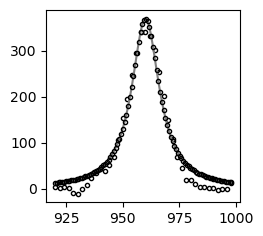

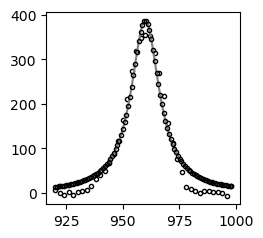

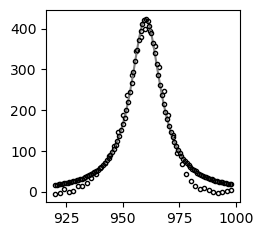

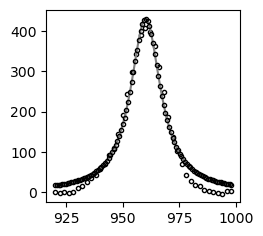

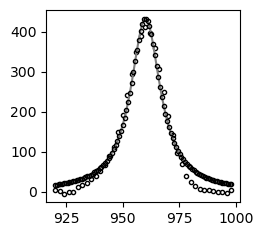

In [18]:
v1PO4_param = v1PO4_analysis(corrcounts, out_directory, fit_plot = True)

### $v_2PO_4$

In [19]:
def v2PO4_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~431 cm-1; right peak ~450 cm-1
         OUTPUT: [0] position of v2PO4 left peak, [1] intensity of v2PO4 left peak, 
                 [2] position of v2PO4 right peak, [3] intensity of v2PO4 right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 354.)[0][0]
    end_index = np.where(shifts.values[0,:] == 516.)[0][0]
    v2PO4_counts = corrcounts.values[:,start_index:end_index] 
    v2PO4_shifts = shifts.values[0,start_index:end_index]
    v2PO4_corrcounts = subtract_peakBG(v2PO4_shifts, v2PO4_counts) #subtracting BG from  v2PO4
    if peak_plot:
        plot_dataframe(v2PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v2PO4.png') # and plot it
    
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = v2PO4_shifts
    for row in range(v2PO4_corrcounts.shape[0]):
        y = v2PO4_corrcounts.values[row,:]
        xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
        xright = x[len(x)//2:]
        yleft = y[:len(y)//2]  
        yright = y[len(y)//2:] 
        bounds = ([0, 420, 0, 0, 445,0], [1e6, 440, 1e6, 1e6, 465, 1e5]) 
        p0 = [2.055*np.std(xleft)/2.0,  431, max(yleft), 2.055*np.std(xright)/2.0,  454, max(yright)]  
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'blue') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()    
    v2PO4_param = {'v2PO4_pos_left': peak_pos_left, 
                   'v2PO4_intensity_left': peak_intensity_left, 
                   'v2PO4_pos_right': peak_pos_right, 
                   'v2PO4_intensity_right': peak_intensity_right, 
                   'v2PO4_integral': peak_integral}
    v2PO4_param = pd.DataFrame(data = v2PO4_param)
    return(v2PO4_param)

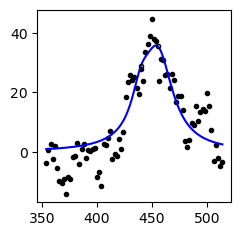

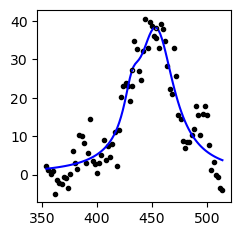

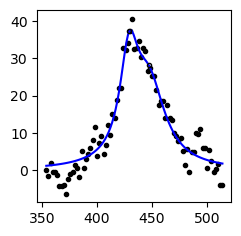

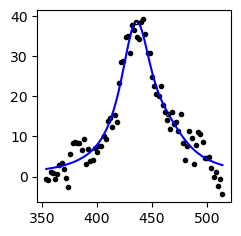

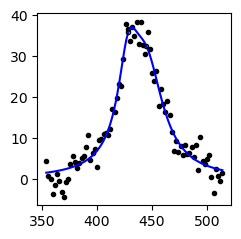

In [20]:
v2PO4_param = v2PO4_analysis(corrcounts, out_directory, fit_plot = True)

### $CO_3$

In [34]:
def CO3_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~431 cm-1; right peak ~450 cm-1
         OUTPUT: [0] position of CO3 left peak, [1] intensity of CO3 left peak, 
                 [2] position of CO3 right peak, [3] intensity of CO3 right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1010.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1110.)[0][0]
    CO3_counts = corrcounts.values[:,start_index:end_index] 
    CO3_shifts = shifts.values[0,start_index:end_index]
    CO3_corrcounts = subtract_peakBG(CO3_shifts, CO3_counts) #subtracting BG from  CO3
    if peak_plot:
        plot_dataframe(CO3_corrcounts,src_directory,nameit, 'BGsubtracted_CO3.png') # and plot it
    
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = CO3_shifts
    for row in range(CO3_corrcounts.shape[0]):
        y = CO3_corrcounts.values[row,:]
        xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
        xright = x[len(x)//2:]
        yleft = y[:len(y)//2]  
        yright = y[len(y)//2:] 
        bounds = ([0, 1020, 0, 0, 1055,0], [1e6, 1050, 1e6, 1e6, 1100, 1e5]) 
        p0 = [2.055*np.std(xleft)/2.0,  1040, max(yleft), 2.055*np.std(xright)/2.0, 1080, max(yright)]  
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'purple') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()    
    CO3_param = {'CO3_pos_left': peak_pos_left, 
                   'CO3_intensity_left': peak_intensity_left, 
                   'CO3_pos_right': peak_pos_right, 
                   'CO3_intensity_right': peak_intensity_right, 
                   'CO3_integral': peak_integral}
    CO3_param = pd.DataFrame(data = CO3_param)
    return(CO3_param)

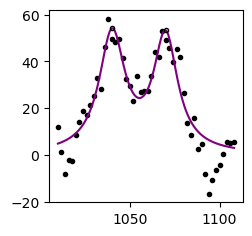

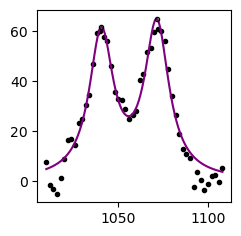

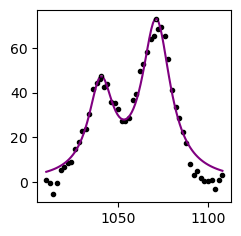

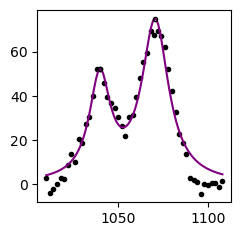

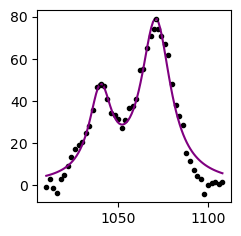

In [35]:
CO3_param = CO3_analysis(corrcounts, out_directory, fit_plot = True)

Creating matrix of Raman bands fit charachteristics:

In [37]:
output_data = pd.concat([amideI_param, amideIII_param], axis=1)
output_data = pd.concat([output_data, v1PO4_param], axis=1)
output_data = pd.concat([output_data, v2PO4_param], axis=1)
output_data = pd.concat([output_data, CO3_param], axis=1)
output_data.head()

,amideI_pos_1,amideI_intensity_1,amideI_pos_2,amideI_intensity_2,amideI_pos_3,amideI_intensity_3,amideI_integral,amideIII_pos_1,amideIII_intensity_1,amideIII_pos_2,...,v2PO4_pos_left,v2PO4_intensity_left,v2PO4_pos_right,v2PO4_intensity_right,v2PO4_integral,CO3_pos_left,CO3_intensity_left,CO3_pos_right,CO3_intensity_right,CO3_integral
0,1598.286847,110.920164,1632.706122,36.965824,1672.699798,21.813872,4926.172788,1239.657710,33.609826,1288.055810,...,439.998731,28.932000,455.407600,35.461872,1781.395857,1040.141298,54.250584,1069.894471,53.440580,2331.907145
1,1597.987351,104.546345,1634.944565,43.766467,1672.693608,40.189669,5350.241623,1241.990611,35.756478,1286.494993,...,431.939884,27.180483,453.727569,38.252188,2204.906018,1040.611895,61.653021,1071.467718,64.953494,2690.686081
2,1601.234631,43.131727,1641.968782,36.928158,1672.142315,39.444818,3645.471599,1242.342388,36.172851,1285.948062,...,429.293301,37.192777,447.279299,28.051263,1823.476471,1040.363142,47.261646,1071.157497,73.080879,2787.744206
3,1600.416860,45.461400,1642.880475,34.799746,1671.205639,39.390640,3513.195438,1242.691563,36.110610,1286.197807,...,435.703700,38.736896,465.000000,15.596720,2086.227579,1039.836641,52.247819,1070.595211,75.041800,2740.244540
4,1601.155294,46.797517,1639.998498,40.793943,1671.237497,44.533776,3911.048356,1242.749106,35.535677,1286.339285,...,428.656660,36.015029,445.000000,32.462433,1998.192612,1040.168332,48.107548,1070.956738,79.107288,2951.221792


Calculating mineral to matrix ratio as the intergral area ratio of $\frac{v_2PO_4}{amide III}$ 

and adding directly to the output dataframe:

In [38]:
output_data['M2M_ratio_v1/a1'] = output_data['v1PO4_integral']/output_data['amideI_integral']
output_data['M2M_ratio_v1/a1']

0    1.545712
1    1.518433
2    2.574777
3    2.710154
4    2.421380
Name: M2M_ratio_v1/a1, dtype: float64

In [39]:
output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']
output_data['M2M_ratio_v2/a3']

0    0.826204
1    0.785923
2    0.629086
3    0.672656
4    0.586160
Name: M2M_ratio_v2/a3, dtype: float64

In [40]:
output_data['crystallinity'] = 1/output_data['v1PO4_FWHM']
output_data['crystallinity']

0    0.067213
1    0.065814
2    0.061834
3    0.061856
4    0.062594
Name: crystallinity, dtype: float64

In [41]:
output_data['carbonate_substitution'] = output_data['CO3_integral']/output_data['v1PO4_integral']
output_data['carbonate_substitution']

0    0.306248
1    0.331203
2    0.297002
3    0.287802
4    0.311635
Name: carbonate_substitution, dtype: float64

Next are the functions for qualitative and quantitative comparison between the two samples:
- Averaged spectra plot
- Boxplots of chosen Raman ratios


In [54]:
def plotSpectra_meanSD(df_mean,df_sd,plot_file, each_sample = False, all_sample = False):
    plt.figure(figsize=(10, 6)) 
    plt.ioff()
    ax = plt.gca()
    for i in range(df_mean.shape[0]):
        if all_sample:
            plot_label = 'Sample '+ df_mean['Sample'][i]
            plt.plot(df_mean.iloc[i,2:], linewidth=2, label=plot_label) #
            plt.fill_between(df_mean.columns[2:].tolist(),
                            df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') + df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                            df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') - df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                             alpha=0.4)  # Adjust transparency as needed
            plt.title('All samples averaged spectrum with SD')
            plt.legend()
        if each_sample:
            plt.plot(df_mean.iloc[i,2:], linewidth=2, color = 'grey') #, label=plot_label
            plt.fill_between(df_mean.columns[2:].tolist(),
                            df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') + df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                            df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') - df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                            color = 'lightgrey', alpha=0.9)  # Adjust transparency as needed
            plt.title('Sample '+s+' averaged spectrum with SD')
    xlim = np.append(1.2*min(df_mean.columns[2:].tolist()), 0.9*max(df_mean.columns[2:].tolist())) # left and right boundaries for x axis
    ax.set_xlim(xlim) # set x axis boundaries
    ax.set_ylim(1.5*min(df_mean.iloc[0,2:]), 1.5*max(df_mean.iloc[0,2:])) # set x axis boundaries
    plt.xlabel('Raman Shifts [cm-1]')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')   


def boxplot(df,y_column, x_column, plot_title, x_label, y_label, plot_file):
    plt.figure(figsize=(8, 8))  # Adjust figure size as needed
    ax = plt.gca()
    sns.boxplot(data=df, x=x_column, y=y_column, hue=x_column)
    sns.swarmplot(data=df, x=x_column, y=y_column, color='black', size=7, alpha=0.7, dodge=True)
    plt.title(plot_title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=14, rotation=45)  # Increase x-axis tick labels font size
    plt.yticks(fontsize=14)  # Increase y-axis tick labels font size
    ax.set_ylim(0.8*min(df[y_column]),1.2*max(df[y_column])) # set x axis boundaries
    plt.grid(True)
    #p-values
    # samples = df[x_column].unique()
    # for i in range(len(samples)):
    #     for j in range(i + 1, len(samples)):
    #         sample1 = df[df[x_column] == samples[i]][y_column]
    #         sample2 = df[df[x_column] == samples[j]][y_column]
    #         p_value = ttest_ind(sample1, sample2).pvalue
    #         asterisk_height = 1.001*max(max(sample1),max(sample2))+0.08*(i+j) # Adjust height of asterisks
    #         if p_value > 0.05:
    #             # plt.text((i + j) / 2, 1.02*asterisk_height, 'p = '+str(np.round(p_value,3)), ha='center', va='center', fontsize=16)  # Adjust position and font size as needed
    #             plt.text((i + j) / 2, 1.02*asterisk_height, 'ns', ha='center', va='center', fontsize=16)  # Adjust position and font size as needed
    #             plt.plot([i, j], [asterisk_height, asterisk_height], color='dimgrey', lw=2)  # Add brackets
    #         if p_value < 0.05:
    #             plt.plot([i, j], [asterisk_height, asterisk_height], color='dimgrey', lw=1)  # Add brackets
    #             if p_value <= 0.05 and p_value > 0.01:
    #                 plt.text((i + j) / 2, 1.01*asterisk_height, '*', ha='center', va='center', fontsize=14)   
    #             if p_value <= 0.01 and p_value > 0.001:
    #                 plt.text((i + j) / 2, 1.01*asterisk_height, '* *', ha='center', va='center', fontsize=14)
    #             if p_value <= 0.001 and p_value > 0.0001:
    #                 plt.text((i + j) / 2, 1.01*asterisk_height, '* * *', ha='center', va='center', fontsize=14)
    #             if p_value <= 0.0001:
    #                 plt.text((i + j) / 2, 1.01*asterisk_height, '* * * *', ha='center', va='center', fontsize=14) 
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    #plt.show()

## Batch analysis part

In [42]:
# Extracting sample names from available folders within "/data"
sample_names = set()
for i in os.listdir(data_directory):
    item_path = os.path.join(data_directory, i)
    if os.path.isdir(item_path):
        sample_names.add(i)
print(sample_names)

{'01.02.PN.023', '01.01.PF.026', '01.01.OA.003', '01.01.BJ.044', '01.01.AA.049', '01.02.LP.047'}


In [46]:
all_output_data = pd.DataFrame()
all_spectraBG_mean = pd.DataFrame()
all_spectraBG_SD = pd.DataFrame()

for s in sample_names:
    sample_dir = data_directory +'/'+ s
    #csv_files = [file for file in os.listdir(sample_dir) if file.endswith('.csv')] #counting number of .csv files
    #spot_number = len(csv_files)
    all_data, nameit = combine_files(sample_dir) #combining all .csv files from sample_dir in one matrix
    spot_names = [name[-5:] for name in nameit]
    corrcounts = subtract_BG(all_data,fitorder=2)  # BG subtraction from ALL data
    plot_dataframe(all_data,sample_dir,nameit,'RawData.png') # Raw spectrs plot
    plot_dataframe(corrcounts,sample_dir,nameit,'BGdata.png',cut = True) # BG subtracted data plot

    #creating mean and SD dataframes
    corrcounts_mean = pd.DataFrame(corrcounts.mean(axis=0)).T #calculating mean spectra from the measurement group
    corrcounts_mean.insert(0, "Sample", s, True)
    corrcounts_sd = pd.DataFrame(corrcounts.std(axis=0)).T  #calculating SD of spectra from the measurement group
    corrcounts_sd.insert(0, "Sample", s, True)   
    plotSpectra_meanSD(df_mean = corrcounts_mean.reset_index(drop=True),
                    df_sd = corrcounts_sd,
                    plot_file = os.path.join(out_directory, s+'_spectra_meanSD.png'),
                    each_sample=True)
        
    all_spectraBG_mean = pd.concat([all_spectraBG_mean, corrcounts_mean], ignore_index=True) # combining all mean spectra into one dataframe
    all_spectraBG_SD = pd.concat([all_spectraBG_SD, corrcounts_sd], ignore_index=True) # combining all SD of spectra into one dataframe

    #Calculating Ramam ratios
    amideI_param = amideI_analysis_triple(corrcounts, sample_dir)
    amideIII_param = amideIII_analysis_triple(corrcounts, sample_dir)
    v1PO4_param = v1PO4_analysis(corrcounts, sample_dir)
    v2PO4_param = v2PO4_analysis(corrcounts, sample_dir)
    CO3_param = CO3_analysis(corrcounts, sample_dir)
    output_data = pd.concat([amideI_param, amideIII_param], axis=1)
    output_data = pd.concat([output_data, v1PO4_param], axis=1)
    output_data = pd.concat([output_data, v2PO4_param], axis=1)
    output_data = pd.concat([output_data, CO3_param], axis=1)
    output_data['M2M_ratio_v1/a1'] = output_data['v1PO4_integral']/output_data['amideI_integral']
    output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']
    output_data['crystallinity'] = 1/output_data['v1PO4_FWHM']
    output_data['carbonate_substitution'] = output_data['CO3_integral']/output_data['v1PO4_integral']
    output_data.insert(0, "Sample", s, True)
    output_data.insert(1, "Spot", spot_names, True)
    all_output_data = pd.concat([all_output_data, output_data], ignore_index=True)
    print("Sample "+ s + " is done!")

Sample 01.02.PN.023 is done!
Sample 01.01.PF.026 is done!
Sample 01.01.OA.003 is done!
Sample 01.01.BJ.044 is done!
Sample 01.01.AA.049 is done!
Sample 01.02.LP.047 is done!


In [55]:
boxplot(df = all_output_data,
                 y_column = 'M2M_ratio_v1/a1',
                 x_column = 'Sample',            
                 plot_title = 'Relative mineralization',
                 x_label = 'Sample',
                 y_label = 'Mineral/Matrix (v1PO4/amide I)',
                 plot_file = os.path.join(out_directory, 'Boxplot_MMRv1a1.png'))

boxplot(df = all_output_data,
                 y_column = 'M2M_ratio_v2/a3',
                 x_column = 'Sample',            
                 plot_title = 'Relative mineralization',
                 x_label = 'Sample',
                 y_label = 'Mineral/Matrix (v2PO4/amide III)',
                 plot_file = os.path.join(out_directory, 'Boxplot_MMRv2a3.png'))

boxplot(df = all_output_data,
                 y_column = 'crystallinity',
                 x_column = 'Sample',            
                 plot_title = 'Mineral crystallinity',
                 x_label = 'Sample',
                 y_label = 'Crystallinity (1/FWHM_v1PO4)',
                 plot_file = os.path.join(out_directory, 'Boxplot_cryst.png'))

boxplot(df = all_output_data,
                 y_column = 'carbonate_substitution',
                 x_column = 'Sample',            
                 plot_title = 'Carbonatesubstitution',
                 x_label = 'Sample',
                 y_label = 'Carbonate substitution (CO3/v1PO4)',
                 plot_file = os.path.join(out_directory, 'Boxplot_carb.png'))


C:\Users\koche\AppData\Local\Temp\ipykernel_31440\4084643647.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))  # Adjust figure size as needed


In [291]:
plotSpectra_meanSD(df_mean = all_spectraBG_mean,
                   df_sd = all_spectraBG_SD,
                   plot_file = os.path.join(out_directory, 'All_samples_spectra_meanSD.png'),
                   all_sample=True)

In [49]:
#saving dataframes
all_output_data.to_csv(os.path.join(out_directory, 'Output_data.csv'))